# Water Mission, IBM

This Notebook offers analytics of water consumption for households in Busiro, Kikondo, and Dei districts of Uganda. It helps to create and update the monthly report from World Bank Data Project. You can find list of the report sections created using this notebook in _The Table of Content_ section below.

The Notebook processes the dataset from Uganda's districts. We assume, that dataset is a separate Excel file for each district. It should have at least 1 sheet with data named "Transaction log". 

To update the dataset you should add new Excel file into Oblect Storage and write its name into proper file container. 

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
 * [Common Figure Rendering Options](#rendering)
* [Data Pre-processing](#preprocessing)
 * [DataFrames Creation](#dataframes)
 * [Functions](#section3)
 * [Data preparation](#section4)
* [Report Data Calculation](#report)
 * [Section 16 - Outages Analysis](#section5)
 * [Appendix (long periods of inactivity before May 2016)](#section6)


<a id="settings"></a>
# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

<a id="variables"></a>
## Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud. 

If you run the notebook on your local system set **environment** variable to **_local_** and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).

In [1]:
environment = 'local'
root = 'c:\\sparknotes\\'
districts = ['Busiro', 'Kikondo', 'Dei', 'Chanhumba'] # Do not change
pattern = r'[a-z]' # Do not change

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [2]:
#@hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'Uganda Transaction logs.xlsx'
}

In [3]:
auth_url = credentials['auth_url']
container = credentials['container']
username = credentials['username']
domain_id = credentials['domain_id']
password= credentials['password']

<a id="imports"></a>
## Library Imports

In [4]:
import time
import math
from __future__ import division, print_function
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from operator import itemgetter
import pylab
from io import BytesIO
import requests
import json
import pandas as pd

from matplotlib import mlab
from __future__ import print_function
import calendar
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id="rendering"></a>
## Common Figure Rendering Options

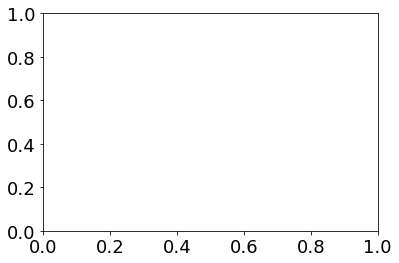

In [5]:
plt.rcParams.update({'font.size': 16})
plt.tick_params(axis='both', which='major', labelsize=18)
fig_size = plt.rcParams["figure.figsize"]
fig_size = [15, 7]
plt.rcParams["figure.figsize"] = fig_size

<a id="preprocessing"></a>
# Data Pre-processing
This section aggregates code to load data, definitions of functions used to pre-process data, and code to prepare data.

<a id="dataframes"></a>
## DataFrames Creation
In this section we load dataset file from and create DataFrame instances for the districts from corresponding tabs in the file.

In [6]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([auth_url, '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': username,'domain': {'id': domain_id},
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url)

The next section defines the dataset to be analyzed: for each site we define a list of files to be loaded and processed. When new data is available, add the files in the corresponding lists.

In [7]:
files_Chanhumba = ['Tanzania Transaction logs - Chanhumba.xlsx']
files_Busiro = ['Uganda Transaction logs - Busiro.xlsx']
files_Kikondo = ['Uganda Transaction logs - Kikondo.xlsx']
files_Dei = ['Uganda Transaction logs - Dei.xlsx']

sheet_name = 'Transaction log' # name of the tab, that contains transaction data

The readFiles function loads files from the specified list and returns a single DataFrame object with aggregated data.

In [8]:
def readFiles(files):
    frames = []
    for file in files:
        xls = pd.ExcelFile(get_file_content(file))
        frames.append(xls.parse(sheet_name))
    return pd.concat(frames)

In [9]:
waterUsageRDD_Kikondo = readFiles(files_Kikondo)
waterUsageRDD_Busiro = readFiles(files_Busiro)
waterUsageRDD_Dei = readFiles(files_Dei)
waterUsageRDD_Chanhumba = readFiles(files_Chanhumba)

<a id="section3"></a>
## Functions
This section defines functions used for data pre-processing.

In [10]:
def getCardDataByDistrict(district):
    if(district == 'Busiro'):
        return waterUsageDF_Busiro
    if(district == 'Kikondo'):
        return waterUsageDF_Kikondo
    if(district == 'Dei'):
        return waterUsageDF_Dei    
    if(district == 'Chanhumba'):
        return waterUsageDF_Chanhumba

In [11]:
def f(x):
    res = x
    if x == 0:
        res = None
    if x == -1:
        res = None
    return res

In [12]:
def movingAverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    
    data = []
    values_sum = 0
      
    if(window > len(values)):
        smas = np.convolve(values, weights, 'same')
        return smas[:len(values)]
        
    for i in range (0,window-1):
        values_sum = values_sum + values[i]
        value = values_sum / (i+1)
        data.append(value)
    
    for i in sma:
        data.append(i)
        
    return data

In [13]:
import calendar

def getCardData(card, district):
    if(district == 'Busiro'):
        d = waterUsageDF_Busiro[waterUsageDF_Busiro.Smartcard_1 == card]
    if(district == 'Kikondo'):
        d = waterUsageDF_Kikondo[waterUsageDF_Kikondo.Smartcard_1 == card]
    if(district == 'Dei'):
        d = waterUsageDF_Dei[waterUsageDF_Dei.Smartcard_1 == card]    
    if(district == 'Chanhumba'):
        d = waterUsageDF_Chanhumba[waterUsageDF_Chanhumba.Smartcard_1 == card]    
    if(len(d) > 0):
        d.Water_dispensed = d.Water_dispensed.astype(float)
        res1=d.groupby(['Date']).Water_dispensed.sum().reset_index()
        res2=d.groupby(['Date']).Balance.min().reset_index()
        res = res1.merge(res2)

        from datetime import datetime
        delta = d.Date.max() - d.Date.min()
        emptyDB = pd.DataFrame(index=pd.date_range(d.Date.min(), periods=delta.days), columns=['Date', 'Water_dispensed', 'Balance'])
        emptyDB.Date = pd.date_range(d.Date.min(), periods=delta.days)
        emptyDB.Water_dispensed = 0
        emptyDB.Balance = 0

        r = pd.concat([emptyDB, res.set_index('Date', drop=False)], ignore_index=True, join='outer')

        result1 = r.groupby(['Date']).Water_dispensed.sum().reset_index()
        result2 = r.groupby(['Date']).Balance.max().reset_index()
        result = result1.merge(result2)
        x = [1.0]
        for row in result.itertuples():
            if(row[3] == 0):
                d = result[(result.Date <= row[1]) & (result.Balance > 0)]
                x.append(d[d.Date == d.Date.max()].Balance.max())
            else:
                x.append(row[3])    

        result['DayBalance'] = x[1:]
        result['MA10'] = movingAverage(result.Water_dispensed,10)
        return result.fillna(0)
    else:
        return pd.DataFrame()


In [14]:
def Busiro119vs121():
    r1 = resultset_outages[resultset_outages.Dispenser == 'Busiro 119']
    r2 = resultset_outages[resultset_outages.Dispenser == 'Busiro 121']
    r1 = r1.groupby(['Hour']).DeltaMinutes.sum().reset_index()
    r2 = r2.groupby(['Hour']).DeltaMinutes.sum().reset_index()
    #r2 = r2.append({"Hour": 17, 'DeltaMinutes': 0.7}, ignore_index=True)

    r = pd.merge(r1, r2, on=['Hour'])
    r.Hour = r.Hour.map(lambda x: str(x) + ':00')
    r = r[r.Hour != '7:00']

    r.index = r.Hour
    r.columns = ['Hour', 'Kiosk 119', 'Kiosk 121']
    
    r = r[['Kiosk 119', 'Kiosk 121']]
    r['Kiosk 119'] = r['Kiosk 119']/60
    r['Kiosk 121'] = r['Kiosk 121']/60    
    
    ax = r.plot(kind='bar',title='Outages by hour, Busiro, Kiosk 119 and Kiosk 121');
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Number of outages')
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    
    return r.reset_index()

In [15]:
def getOutagesDays(res):
    kikondo = res[res.Dispenser == 'Kikondo 117']
    dei = res[res.Dispenser == 'Dei 010']
    busiro119 = res[res.Dispenser == 'Busiro 119']
    busiro121 = res[res.Dispenser == 'Busiro 121']
    
    chanhumbaNyerere = res[res.Dispenser == 'Nyerere']
    chanhumbaZahanati = res[res.Dispenser == 'Zahanati']
    chanhumbaArusha_B = res[res.Dispenser == 'Arusha B']
    chanhumbaIringa = res[res.Dispenser == 'Iringa']
    chanhumbaChangombe = res[res.Dispenser == "Chang'ombe"]
    
    return getEmptyDB(kikondo).append(getEmptyDB(dei)).append(getEmptyDB(busiro119)).append(getEmptyDB(busiro121)).append(getEmptyDB(chanhumbaNyerere)).append(getEmptyDB(chanhumbaZahanati)).append(getEmptyDB(chanhumbaArusha_B)).append(getEmptyDB(chanhumbaIringa)).append(getEmptyDB(chanhumbaChangombe))

def getEmptyDB(d):
    delta = d.Date.max() - d.Date.min()
    emptyDB = pd.DataFrame(index=pd.date_range(d.Date.min(), periods=delta.days), columns=['Date', 'Dispenser', 'Water_dispensed'])
    emptyDB.Date = pd.date_range(d.Date.min(), periods=delta.days)
    emptyDB.Dispenser = d.get_value(d.index[0],'Dispenser')
    emptyDB.Water_dispensed = 0
    res = pd.concat([emptyDB, d.set_index('Date', drop=False)], ignore_index=True, join='outer')
    res = res.groupby(['Date', 'Dispenser']).Water_dispensed.sum().reset_index()
    return res

In [16]:
def getOutage(x):
    dispenser = x[3]
    hour = x[2]
    delta = x[7]    
        
    if(dispenser == 'Busiro 119'):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'       
    
    if(dispenser == 'Busiro 121'):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'       
    
    if(dispenser == 'Kikondo 117'):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'       
    
    if(dispenser == 'Dei 010'):
        if((hour <= 18) & (hour >= 8) & (delta > 90)):
            return 'Outage'  
        
    if(dispenser == "Chang'ombe"):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'  
    if(dispenser == "Iringa"):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'  
    if(dispenser == "Arusha B"):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'  
    if(dispenser == "Zahanati"):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'  
    if(dispenser == "Nyerere"):
        if((hour <= 18) & (hour >= 6) & (delta > 90)):
            return 'Outage'  
    return ''

In [17]:
# get max interval between transactions (use for stopped cards determining)
def calculateInterval(card, district):
    percentage = 5
    data = cardsHistory[cardsHistory.District == district]
    cardData = data[data.Smartcard_1 == card]
     
    initAr = list(cardData.Date)

    ar = (len(initAr) - 1) * [0]
    
    for index in range(len(initAr) - 1):
        ar[index] = (initAr[index+1] - initAr[index]).days
    ar.sort()
    
    values = 2
    if(len(ar) * percentage / 100) > 2:
        values = int(round(len(ar) * percentage / 100) )
    
    if(values > len(ar)):
        values = len(ar)
    
    if(values  == 0):
        maxIntervalOfUsage = 0
    else:
        maxIntervalOfUsage = round(sum(ar[-values:])/values)
    
    if(maxIntervalOfUsage > 0):
        if(maxIntervalOfUsage < 30):
            maxIntervalOfUsage = 30
    
    return maxIntervalOfUsage

def getInterval(x):
    card = x[0] 
    district = x[1] 
    return calculateInterval(card, district)

def findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge):
    res = 'Running'
    if ((endDate - lastUsageDate).days > interval):
        if (float(lastBalance) > balanceLowerEdge):
            res = 'Stopped with credits'
        else:
            res = 'Stopped without credits'
    
    return res

# get card status: Running, stopped with credits or stopped without credits 
def getStatus(x):
    card = x[0] 
    district = x[1] 
    endDate = x[2]
    lastUsageDate = x[3]
    lastBalance = x[4]
    interval = x[5]
    return findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge)

# find how many times card was renewed, what is the average amount of deposit, min balance before deposit and average balance before deposit 
def getCreditInfoByDistrict(district):
    data = getCardDataByDistrict(district)    
    data.Balance = data.Balance.astype(float).fillna(0)
    data.Credits = data.Credits.astype(float).abs().fillna(0)
    d1 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Balance.min().reset_index()
    d2 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Credits.sum().reset_index()
    df = pd.merge(d1, d2, on = ['Smartcard_1','Date', 'Date_and_time'])
    df.Date_and_time = pd.to_datetime(df.Date_and_time)
    df = df.sort_values(['Smartcard_1','Date', 'Date_and_time'], ascending=[True, True, True])
    df['Balance_diff'] = df.groupby('Smartcard_1')['Balance'].diff().fillna(0)
    df = df[(df.Balance_diff > 0)]
    df.Credits = df.Credits + df.Balance_diff
    df['Balance_prev'] = df.Balance - df.Balance_diff
    prevMin = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].min()
    prevAve = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].mean()
    count = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_diff'].count()
    ave = df[df.Balance_diff > 0].groupby('Smartcard_1')['Credits'].mean()
    result = pd.concat([count, ave, prevMin, prevAve], axis = 1).reset_index()
    result = result.fillna(0)
    result.columns = ['Smartcard_1', 'Credits_Add', 'Add_Credits_Mean', 'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean']
    return result

In [18]:
def creditGroup(y):
    x = abs(y)
    if (x >= 0) & (x < 25):
        return 1
    if (x >= 25) & (x < 50):
        return 2
    if (x >= 50) & (x < 75):
        return 3
    if (x >= 75) & (x < 100):
        return 4
    if (x >= 100) & (x < 125):
        return 5
    if (x >= 125) & (x < 150):
        return 6
    if (x >= 150) & (x < 175):
        return 7
    if (x >= 175) & (x < 200):
        return 8
    if (x >= 200) & (x < 225):
        return 9
    if (x >= 225) & (x < 250):
        return 10
    if (x >= 250) & (x < 275):
        return 11
    if (x >= 275) & (x < 300):
        return 12
    if (x >= 300):
        return 13
  
    return 0

In [19]:
def renewBalanceGroup(x):
    if (x >= 0) & (x < 200):
        return 1
    if (x >= 200) & (x < 400):
        return 2
    if (x >= 400) & (x < 600):
        return 3
    if (x >= 600) & (x < 800):
        return 4
    if (x >= 800) & (x < 1000):
        return 5
    if (x >= 1000) & (x < 1200):
        return 6
    if (x >= 1200):
        return 7
  
    return 0

<a id="section4"></a>
## Data preparation

Remove rows with empty 'Smartcard 1' values, drop duplicates, convert date and time, add district name

In [20]:
def cleanData(waterUsageDF, districtName):
    waterUsageDF = waterUsageDF[~waterUsageDF['Smartcard 1'].isnull()]
    if(waterUsageDF['Smartcard 1'].dtype != 'object'):
        waterUsageDF['Smartcard 1'] = waterUsageDF['Smartcard 1'].astype(int).astype(str)   
    waterUsageDF_2 = waterUsageDF[(waterUsageDF['Smartcard 1'].str.contains(pattern) != True) & (waterUsageDF['Smartcard 1'] != '')]
    waterUsageDF_2.columns = ['Transaction_id','Date_and_time','Dispenser','Operation','Smartcard_1','Smartcard_2','Water_dispensed','Credits','Balance','Total_created']
    waterUsageDF_2 = waterUsageDF_2.drop_duplicates().reset_index(drop=True)
    
    waterUsageDF_2.Date_and_time = pd.to_datetime(waterUsageDF_2.Date_and_time, format='%d-%m-%Y %H:%M:%S')
    waterUsageDF_2['Date'] = waterUsageDF_2.Date_and_time.dt.date
    waterUsageDF_2.Date = pd.to_datetime(waterUsageDF_2.Date, format='%Y-%m-%d')
    
    waterUsageDF_2['District'] = districtName
    
    return waterUsageDF_2

In [21]:
waterUsageDF_Busiro = cleanData(waterUsageRDD_Busiro, 'Busiro')
waterUsageDF_Kikondo = cleanData(waterUsageRDD_Kikondo, 'Kikondo')
waterUsageDF_Dei = cleanData(waterUsageRDD_Dei, 'Dei')
waterUsageDF_Chanhumba = cleanData(waterUsageRDD_Chanhumba, 'Chanhumba')

Let's move transactions for 'vendor' cards into a separate set, and remove them from the dataset

In [22]:
vendor_cards = {'1604', '1605', '2281', '2283', '2284', '2291', '2292', '2954'}
vendors = waterUsageDF_Kikondo[waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)] 
vendors = vendors.append(waterUsageDF_Busiro[waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)])

waterUsageDF_Busiro = waterUsageDF_Busiro[~waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)] 
waterUsageDF_Kikondo = waterUsageDF_Kikondo[~waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)]

Save datasets with all types of operation for future

In [23]:
waterUsageDF_Busiro_allOperations = waterUsageDF_Busiro
waterUsageDF_Kikondo_allOperations = waterUsageDF_Kikondo
waterUsageDF_Dei_allOperations = waterUsageDF_Dei
waterUsageDF_Chanhumba_allOperations = waterUsageDF_Chanhumba

allOperations = waterUsageDF_Busiro_allOperations.append(waterUsageDF_Kikondo_allOperations).append(waterUsageDF_Dei).append(waterUsageDF_Chanhumba).append(vendors)
allOperations = allOperations[~allOperations.Smartcard_1.isnull()]

Let's remove from from the dataset all operations different to Water dispensed, and further clean the data

In [24]:
def cleanData2(waterUsageDF):
    waterUsageDF = waterUsageDF[(waterUsageDF.Operation == 'Water dispensed')]
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.replace(to_replace='.0', value='', regex=False)
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.astype(int).astype(str)
    waterUsageDF = waterUsageDF[(waterUsageDF.Smartcard_1 != '')]
    return waterUsageDF

In [25]:
waterUsageDF_Busiro = cleanData2(waterUsageDF_Busiro)
waterUsageDF_Kikondo = cleanData2(waterUsageDF_Kikondo)
waterUsageDF_Dei = cleanData2(waterUsageDF_Dei)
waterUsageDF_Chanhumba = cleanData2(waterUsageDF_Chanhumba)


Clean the aggregated data as well

In [26]:
allOperations.Smartcard_1 = allOperations.Smartcard_1.replace(to_replace='.0', value='', regex=False)
allOperations.Smartcard_2 = allOperations.Smartcard_2.replace(to_replace='.0', value='', regex=False)

allOperations.Smartcard_1 = allOperations.Smartcard_1.astype(int).astype(str)

allOperations = allOperations[(allOperations.Smartcard_1 != '')]

Prepare data related to credits

In [27]:
def prepareCreditsData(waterUsageDF, districtName):
    credits = getCreditInfoByDistrict(districtName)
    result = pd.merge(waterUsageDF, credits, on='Smartcard_1', how='left')
    result['District'] = districtName
    result['EndDate'] = waterUsageDF.Date.max()
    return result

busiroResult = prepareCreditsData(waterUsageDF_Busiro, 'Busiro')
kikondoResult = prepareCreditsData(waterUsageDF_Kikondo, 'Kikondo')
deiResult = prepareCreditsData(waterUsageDF_Dei, 'Dei')
chanhumbaResult = prepareCreditsData(waterUsageDF_Chanhumba, 'Chanhumba')

In [28]:
result = pd.DataFrame(busiroResult.append(kikondoResult).append(deiResult).append(chanhumbaResult), 
                columns=['Transaction_id','Date','Date_and_time','EndDate','District','Dispenser','Smartcard_1','Water_dispensed',
                'Credits','Balance','Credits_Add','Add_Credits_Mean','Balance_Before_Credit_Min','Balance_Before_Credit_Mean'])

transaction_Count = result.groupby(['District','Smartcard_1'])['Transaction_id'].count().reset_index()
water_dispensed_Mean = result.groupby(['District','Smartcard_1'])['Water_dispensed'].mean().reset_index()
first_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].min().reset_index()
last_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].max().reset_index()

d1 = pd.merge(transaction_Count, water_dispensed_Mean, on=['District','Smartcard_1'], how='left')
d2 = pd.merge(first_Usage_Date, last_Usage_Date, on=['District','Smartcard_1'], how='left')
additionalDB = pd.merge(d1, d2, on=['District','Smartcard_1'], how='left')
additionalDB.columns = ['District', 'Smartcard_1', 'Transaction_Count', 'Water_dispensed_Mean', 'First_Usage_Date', 'Last_Usage_Date']
resultset = pd.merge(result, additionalDB, on=['District','Smartcard_1'], how='left')

In [29]:
cardData1 = allOperations.groupby(['District','Smartcard_1', 'Date']).Water_dispensed.sum()
cardData2 = allOperations.groupby(['District','Smartcard_1', 'Date']).Balance.min()
cardDataRes = pd.concat([cardData1, cardData2], axis = 1).reset_index()
cardsHistory = cardDataRes.sort_values(['District','Smartcard_1', 'Date'], ascending=[True,True,True]).reset_index(drop=True)

lastBalance = cardsHistory.groupby(['District','Smartcard_1']).Balance.last().reset_index()
lastBalance.columns = ['District','Smartcard_1','LastBalance']

cardsMaxInterval = pd.DataFrame(lastBalance, columns=['Smartcard_1', 'District'], index = lastBalance.index).drop_duplicates().reset_index(drop=True)
cardsMaxInterval.loc[:,'Interval'] = cardsMaxInterval.apply(getInterval, axis = 1)

resultset = pd.merge(resultset, lastBalance, on=['District','Smartcard_1'], how='left')
resultset = pd.merge(resultset, cardsMaxInterval, on=['District','Smartcard_1'], how='left')
resultset.LastBalance = resultset.LastBalance.astype(float)

balanceLowerEdge = 15

cardsStatus = pd.DataFrame(resultset, columns=['Smartcard_1', 'District', 'EndDate', 
                                               'Last_Usage_Date', 'LastBalance', 'Interval'], index = resultset.index).drop_duplicates().reset_index(drop=True)
cardsStatus.loc[:,'Status'] = cardsStatus.apply(getStatus, axis = 1)

In [30]:
resultset = pd.merge(resultset, cardsStatus, on=['Smartcard_1', 'District', 'EndDate', 'Last_Usage_Date', 'LastBalance', 'Interval'], how='left')
resultset.LastBalance = resultset.LastBalance.fillna(0)
resultset['CreditGroup'] = pd.Series(resultset.Credits, index=resultset.index).apply(creditGroup)

<a id="report"></a>
# Report Data Calculation

<a id="section5"></a>
## Section 16 - Outages Analysis

One of investigation tasks is to look at the service outages and how the community reacts after the outage occurs. We can figure out two types of outages: severe outages can be found in the data relatively easily (like zero consumption in a particular day), and smaller outages that might be found by looking at the hourly usage profile (for instance, no water is dispensed after 2 PM, while usually people get water until 6 PM).

In [31]:
serviceLog_Kikondo = pd.read_csv(get_file_content('Service Log Kikondo.csv'), sep = ';')
serviceLog_Busiro = pd.read_csv(get_file_content('Service Log Busiro.csv'), sep = ';')
serviceLog_Dei = pd.read_csv(get_file_content('Service Log Dei.csv'), sep = ';')
serviceLog_Kikondo.columns = ['Type','Code','TimeRaised','TimeCleared','Description','Dispenser', 'TMP']
serviceLog_Busiro.columns = ['Type','Code','TimeRaised','TimeCleared','Description','Dispenser', 'TMP']
serviceLog_Dei.columns = ['Type','Code','TimeRaised','TimeCleared','Description','Dispenser']

In [32]:
serviceLog_Kikondo.TimeRaised =  pd.to_datetime(serviceLog_Kikondo.TimeRaised, format='%d.%m.%Y %H:%M')
serviceLog_Busiro.TimeRaised =  pd.to_datetime(serviceLog_Busiro.TimeRaised, format='%d.%m.%Y %H:%M')
serviceLog_Dei.TimeRaised =  pd.to_datetime(serviceLog_Dei.TimeRaised, format='%d.%m.%Y %H:%M')
serviceLog_Kikondo.TimeCleared =  pd.to_datetime(serviceLog_Kikondo.TimeCleared, format='%d.%m.%Y %H:%M')
serviceLog_Busiro.TimeCleared =  pd.to_datetime(serviceLog_Busiro.TimeCleared, format='%d.%m.%Y %H:%M')
serviceLog_Dei.TimeCleared =  pd.to_datetime(serviceLog_Dei.TimeCleared, format='%d.%m.%Y %H:%M')

In [33]:
serviceLog_Kikondo = serviceLog_Kikondo[['Type','Code','TimeRaised','TimeCleared','Description','Dispenser']]
serviceLog_Busiro = serviceLog_Busiro[['Type','Code','TimeRaised','TimeCleared','Description','Dispenser']]
serviceLog_Dei = serviceLog_Dei[['Type','Code','TimeRaised','TimeCleared','Description','Dispenser']]

serviceLog_Kikondo['Date'] = pd.to_datetime(serviceLog_Kikondo.TimeRaised.dt.date)
serviceLog_Busiro['Date'] = pd.to_datetime(serviceLog_Busiro.TimeRaised.dt.date)
serviceLog_Dei['Date'] = pd.to_datetime(serviceLog_Dei.TimeRaised.dt.date)

In [34]:
serviceLog_Kikondo['Delta'] = (serviceLog_Kikondo.TimeCleared - serviceLog_Kikondo.TimeRaised).apply(lambda x: x / np.timedelta64(1,'h')) 
serviceLog_Busiro['Delta'] = (serviceLog_Busiro.TimeCleared - serviceLog_Busiro.TimeRaised).apply(lambda x: x / np.timedelta64(1,'h'))
serviceLog_Dei['Delta'] = (serviceLog_Dei.TimeCleared - serviceLog_Dei.TimeRaised).apply(lambda x: x / np.timedelta64(1,'h'))

serviceLog_All = serviceLog_Kikondo.append(serviceLog_Busiro).append(serviceLog_Dei)

In [35]:
resultset['Hour'] = pd.DatetimeIndex(resultset['Date_and_time']).hour
resultset_outages = resultset[['Date', 'Date_and_time', 'Hour', 'Dispenser', 'Water_dispensed']]
resultset_outages = resultset_outages.sort_values(['Dispenser', 'Date_and_time'], ascending=[True, True])

In [36]:
resultset_outages_zero = getOutagesDays(resultset_outages)
resultset_outages_zero = resultset_outages_zero[resultset_outages_zero.Water_dispensed == 0.0].reset_index(drop = True)

In [37]:
logsInZeroDays = pd.merge(resultset_outages_zero, serviceLog_All, on = ['Dispenser', 'Date'])
logsInZeroDays['Delta'] = (logsInZeroDays.TimeCleared - logsInZeroDays.TimeRaised).apply(lambda x: x / np.timedelta64(1,'h'))

In [38]:
resultset_outages['Time_next'] = resultset_outages.groupby(['Dispenser', 'Date'])['Date_and_time'].shift(-1)
resultset_outages['Delta'] = (resultset_outages.Time_next - resultset_outages.Date_and_time)
resultset_outages['DeltaMinutes'] = (resultset_outages.Time_next - resultset_outages.Date_and_time).apply(lambda x: x / np.timedelta64(1,'m'))
resultset_outages = resultset_outages[(
    ((resultset_outages.Dispenser == 'Nyerere') & (resultset_outages.Hour > 4) & (resultset_outages.Hour < 19)) |
    ((resultset_outages.Dispenser == 'Zahanati') & (resultset_outages.Hour > 4) & (resultset_outages.Hour < 19)) |
    ((resultset_outages.Dispenser == 'Arusha B') & (resultset_outages.Hour > 4) & (resultset_outages.Hour < 19)) |
    ((resultset_outages.Dispenser == 'Iringa') & (resultset_outages.Hour > 4) & (resultset_outages.Hour < 19)) |
    ((resultset_outages.Dispenser == "Chang'ombe") & (resultset_outages.Hour > 4) & (resultset_outages.Hour < 19)) |
    ((resultset_outages.Dispenser == 'Busiro 119') & (resultset_outages.Hour > 4) & (resultset_outages.Hour < 19)) |
    ((resultset_outages.Dispenser == 'Busiro 121') & (resultset_outages.Hour > 6) & (resultset_outages.Hour < 18)) |
    ((resultset_outages.Dispenser == 'Kikondo 117') & (resultset_outages.Hour > 5) & (resultset_outages.Hour < 19)) |
    ((resultset_outages.Dispenser == 'Dei 010') & (resultset_outages.Hour > 8) & (resultset_outages.Hour < 19)) 
)]
resultset_outages['Outage'] = resultset_outages.apply(getOutage, axis = 1)
resultset_outages = resultset_outages[resultset_outages.Outage == 'Outage']

,Hour,Kiosk 119,Kiosk 121
0,8:00,34.045000,20.849444
1,9:00,60.499722,12.723611
2,10:00,53.664444,24.553056
3,11:00,59.388333,30.665000
4,12:00,59.572500,8.714167
5,14:00,54.960278,5.768889
6,15:00,49.017500,11.735556
7,16:00,39.551389,28.476944
8,17:00,90.233889,24.002222


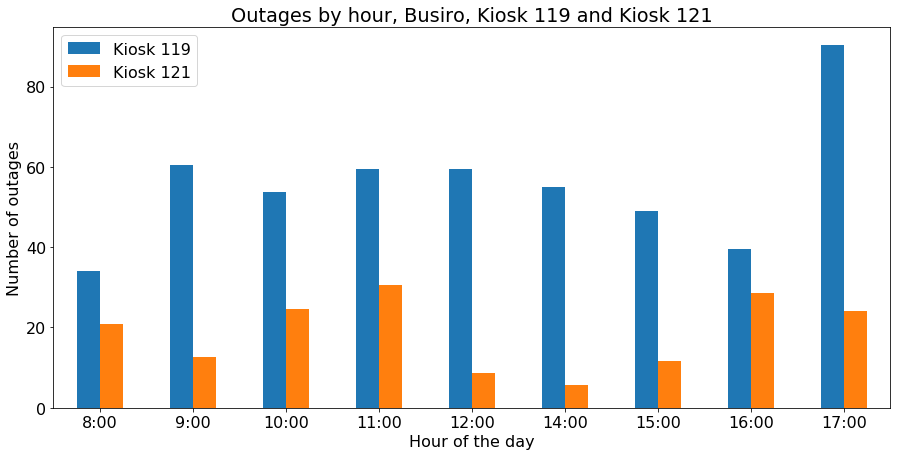

In [39]:
Busiro119vs121()

Busiro 119
     Hour  Overall_outages
0    6:00        48.874722
1    7:00        30.293611
2    8:00        34.045000
3    9:00        60.499722
4   10:00        53.664444
5   11:00        59.388333
6   12:00        59.572500
7   13:00        68.513056
8   14:00        54.960278
9   15:00        49.017500
10  16:00        39.551389
11  17:00        90.233889
12  18:00        98.510278


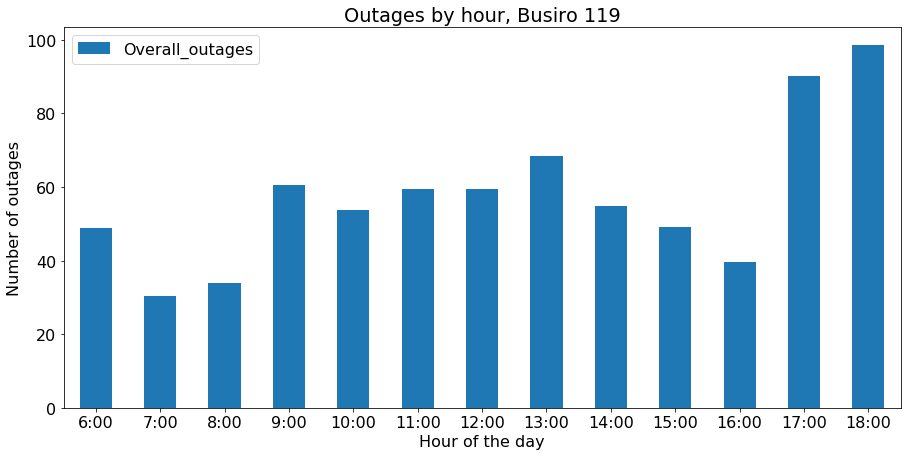

Busiro 121
    Hour  Overall_outages
0   7:00        40.384722
1   8:00        20.849444
2   9:00        12.723611
3  10:00        24.553056
4  11:00        30.665000
5  12:00         8.714167
6  14:00         5.768889
7  15:00        11.735556
8  16:00        28.476944
9  17:00        24.002222


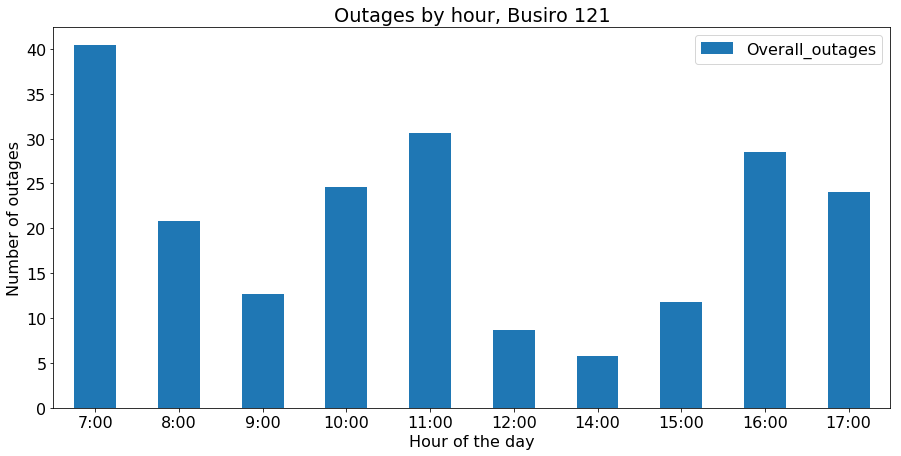

Dei 010
    Hour  Overall_outages
0   9:00        55.772500
1  10:00        42.251111
2  11:00        64.573056
3  12:00        81.553889
4  13:00       100.547222
5  14:00        76.300833
6  15:00        65.000833
7  16:00        51.565833
8  17:00        59.419167
9  18:00       121.814167


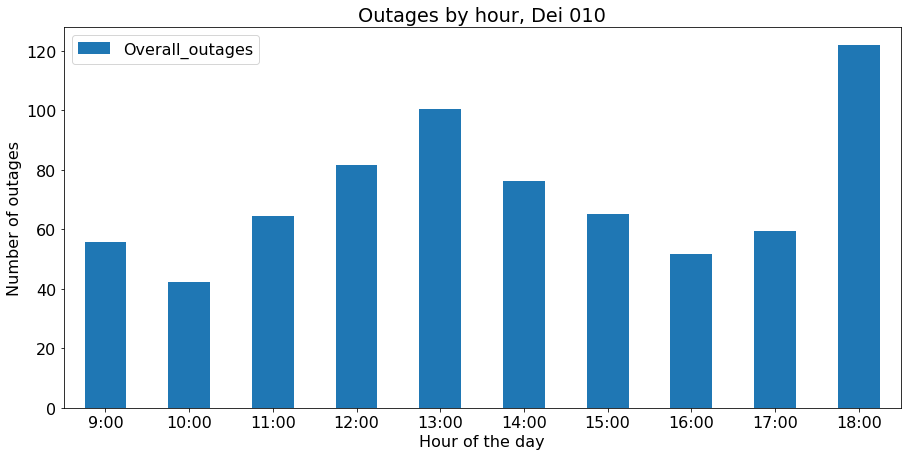

Kikondo 117
     Hour  Overall_outages
0    6:00        16.310833
1    7:00        18.005556
2    8:00        17.677222
3    9:00        29.302778
4   10:00        18.175000
5   11:00        16.909444
6   12:00        12.550000
7   13:00        16.445000
8   14:00         4.024444
9   17:00        21.174444
10  18:00         4.934444


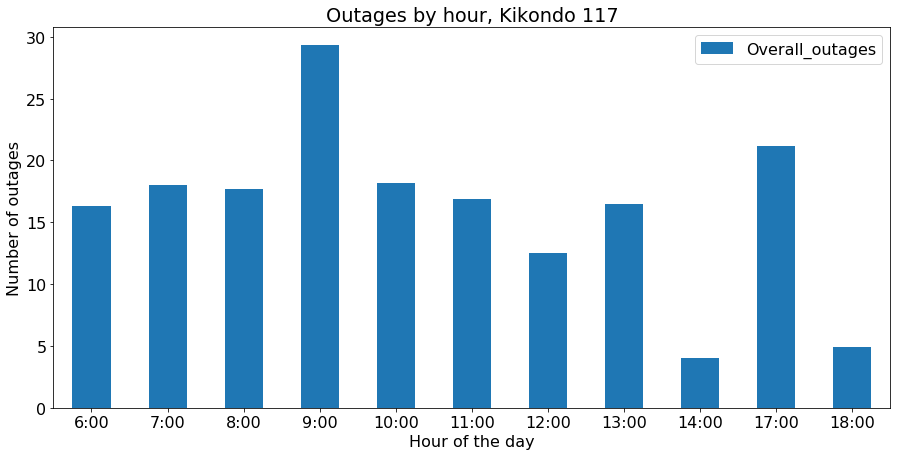

Nyerere
    Hour  Overall_outages
0   8:00        15.600556
1   9:00         5.853889
2  10:00         2.182222
3  11:00         2.182778
4  12:00         1.563056
5  15:00         3.272222
6  17:00         7.016667
7  18:00         6.401111


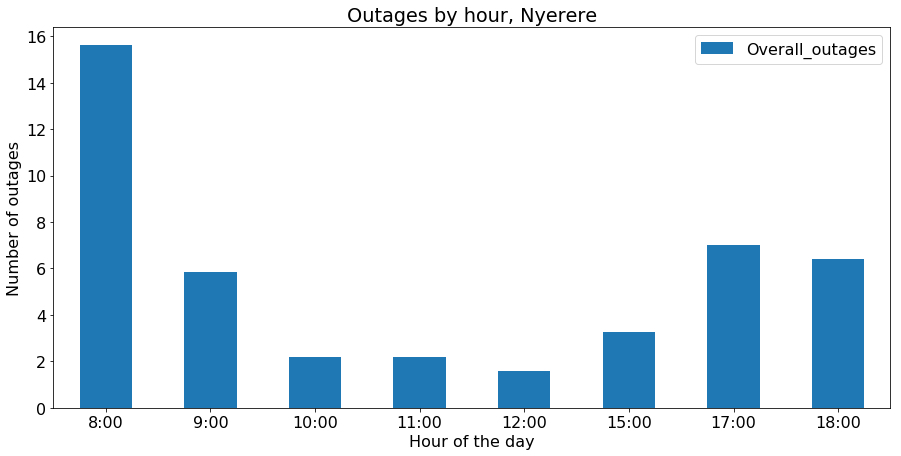

Zahanati
     Hour  Overall_outages
0    6:00        28.723333
1    7:00        35.288056
2    8:00        33.888889
3    9:00        12.559722
4   10:00        22.857778
5   11:00        10.979444
6   12:00        12.234722
7   13:00        25.225278
8   14:00        13.775833
9   15:00         7.536944
10  16:00         6.311667
11  17:00         1.753333
12  18:00         4.138056


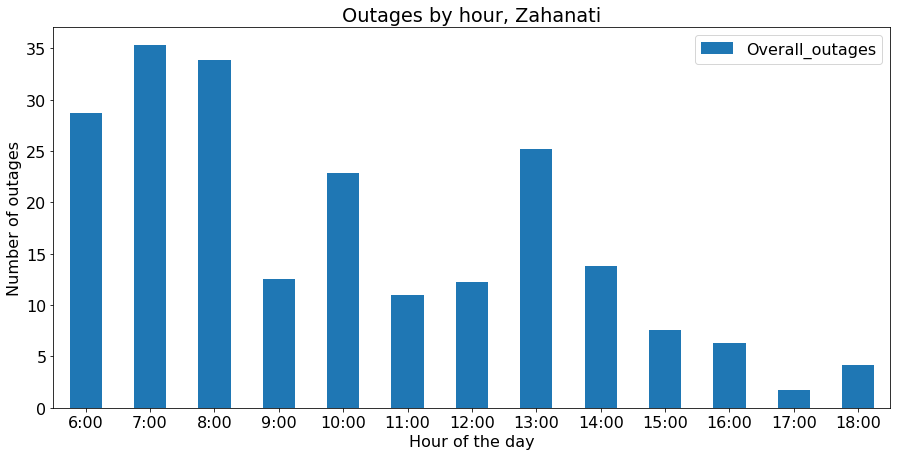

Arusha B
     Hour  Overall_outages
0    7:00         3.335000
1    8:00         2.169444
2    9:00         8.345556
3   10:00         2.766944
4   11:00        12.104167
5   12:00         5.075278
6   13:00         5.759444
7   14:00         9.664722
8   15:00         2.737778
9   16:00         5.312500
10  18:00         6.939444


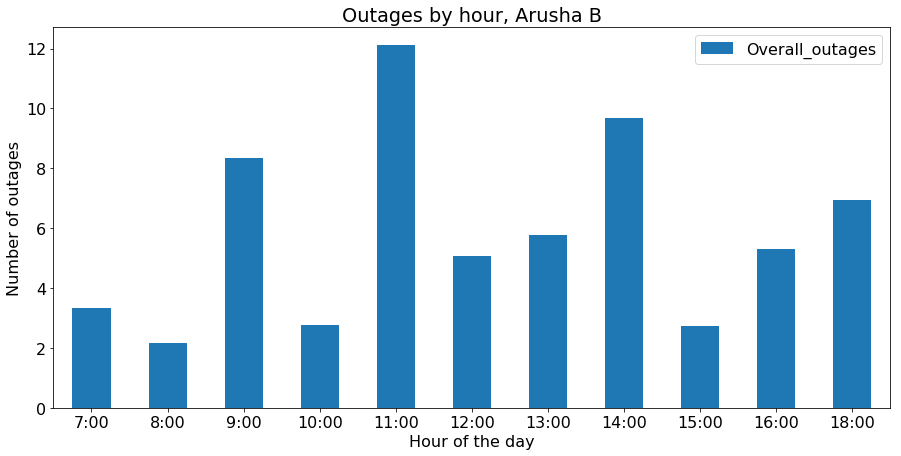

Iringa
     Hour  Overall_outages
0    6:00         5.091389
1    7:00        21.900833
2    8:00         7.928056
3    9:00         4.010556
4   10:00         3.593333
5   11:00         8.330278
6   12:00         5.460278
7   13:00         1.601389
8   15:00         3.635000
9   17:00         6.251111
10  18:00         9.495833


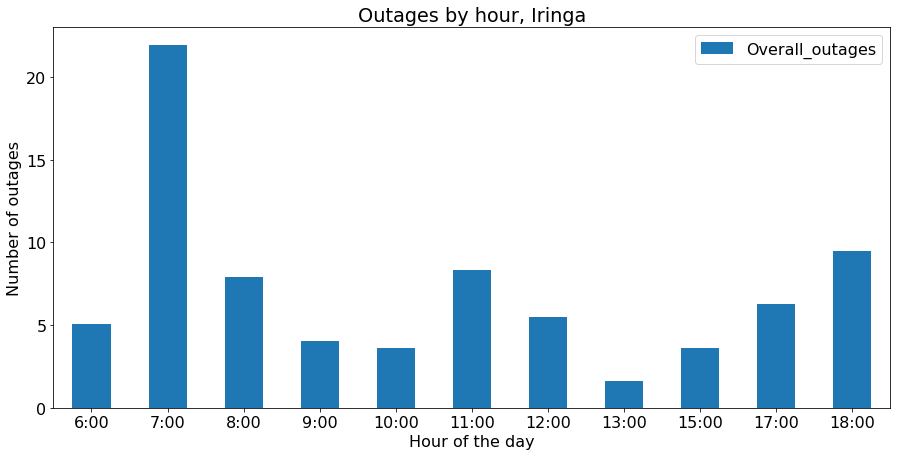

Chang'ombe
    Hour  Overall_outages
0   7:00         3.945556
1   8:00         2.690556
2  12:00         2.220278
3  17:00         1.520000


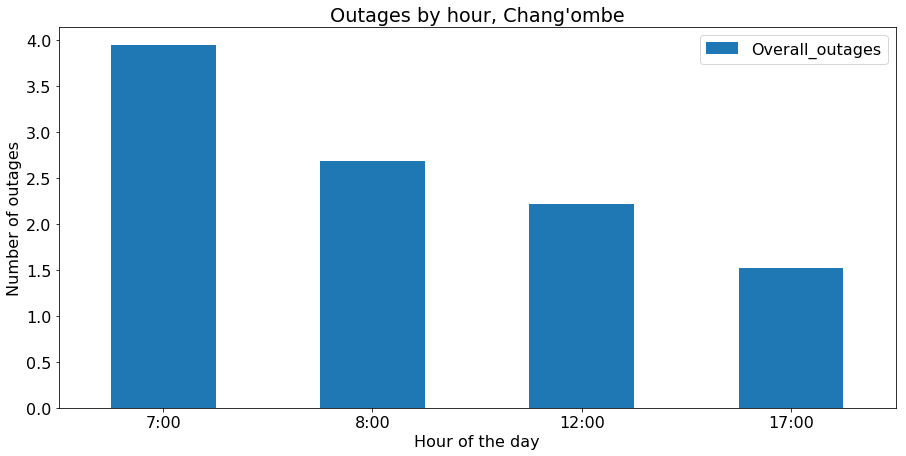

In [40]:
#@interact(dispenser=['Busiro 119', 'Busiro 121', 'Dei 010', 'Kikondo 117'])
def ff(dispenser):
    r = resultset_outages[resultset_outages.Dispenser == dispenser]
    
    r = r.groupby(['Dispenser', 'Hour']).DeltaMinutes.sum().reset_index()
    r.Hour = r.Hour.map(lambda x: str(x) + ':00')

    r.index = r.Hour
    r = r[['DeltaMinutes']]
    r.DeltaMinutes = r.DeltaMinutes/60
    r.columns = ['Overall_outages']
    
    ax = r.plot(kind='bar',title='Outages by hour, ' + dispenser);
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Number of outages')
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)

    print(dispenser)
    print(r.reset_index())
    plt.show()

for dispenser in ['Busiro 119', 'Busiro 121', 'Dei 010', 'Kikondo 117', 'Nyerere', 'Zahanati', 'Arusha B', 'Iringa', "Chang'ombe"]:
    ff(dispenser)

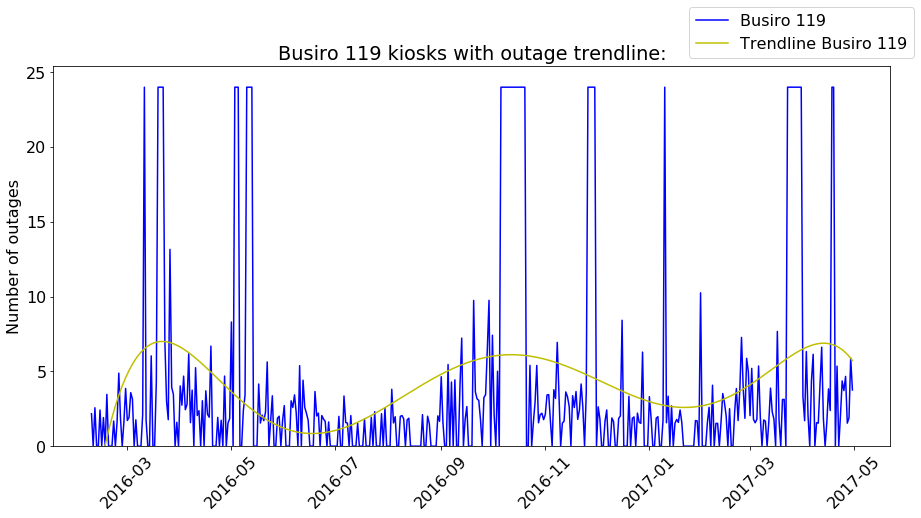

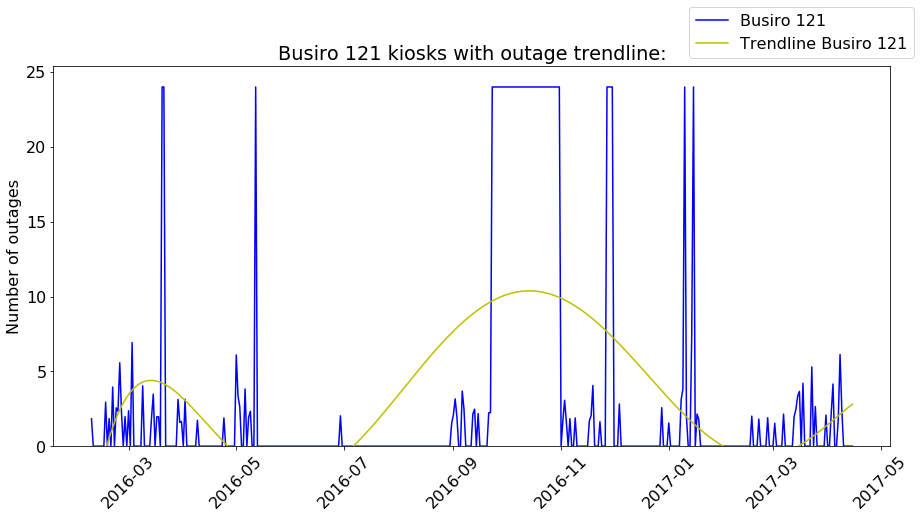

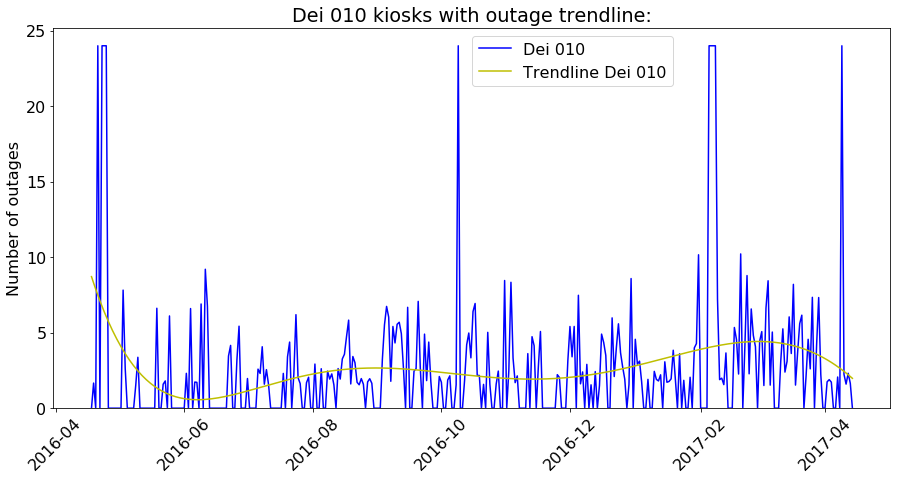

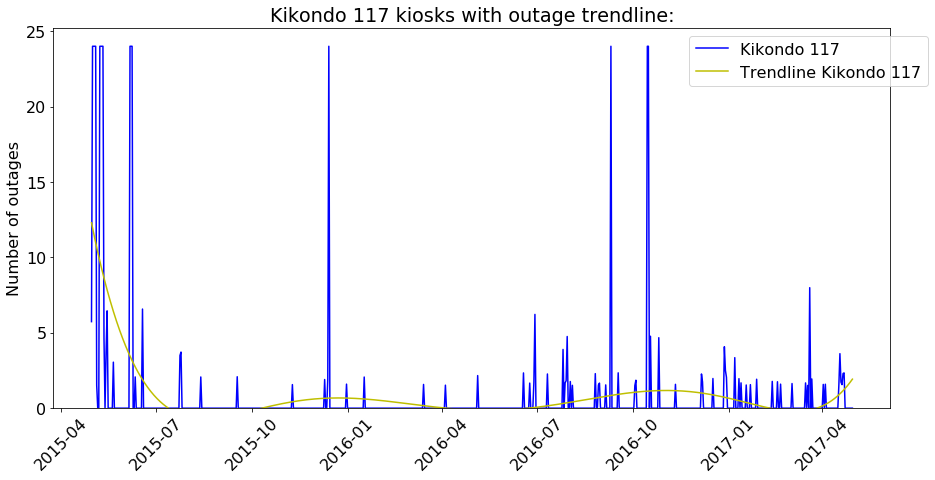

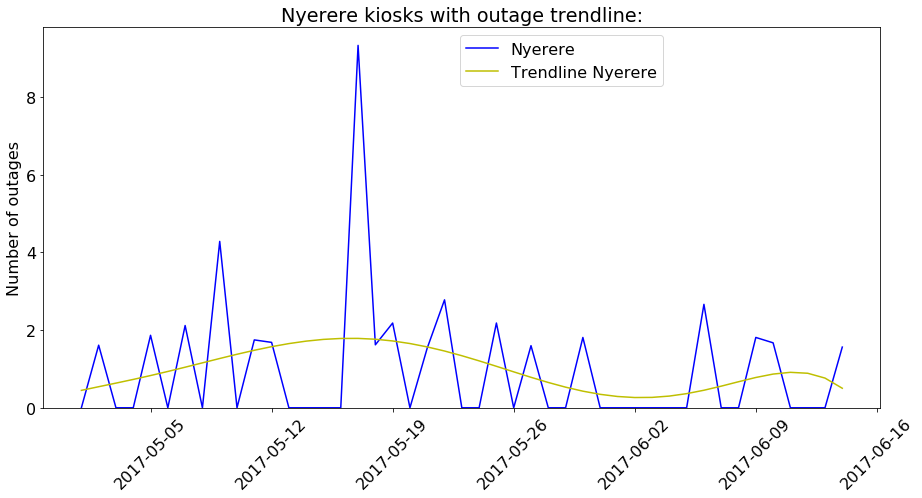

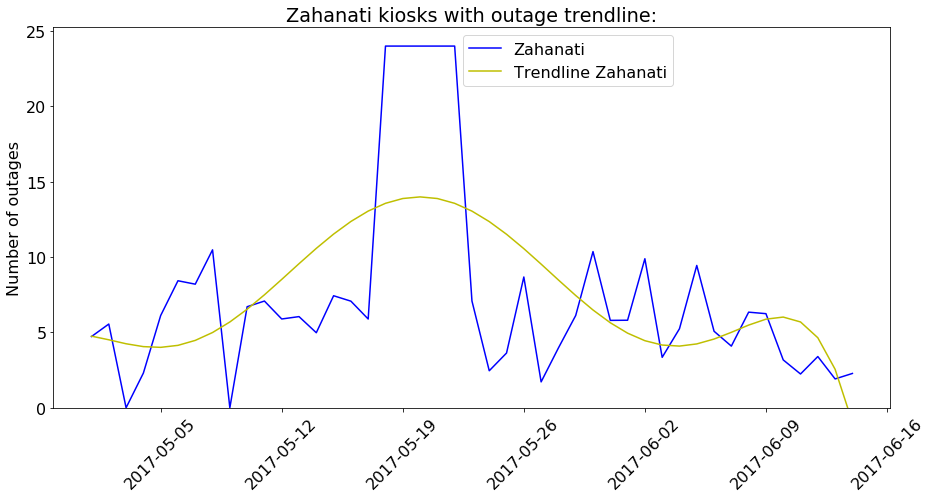

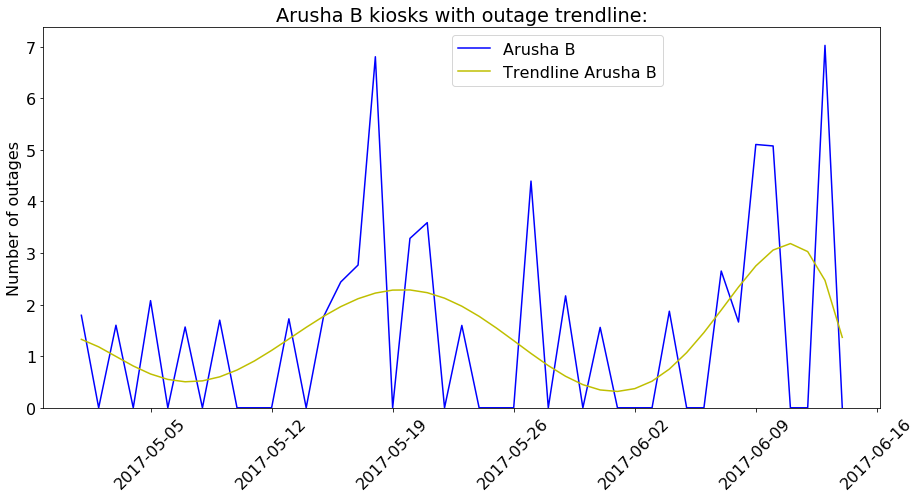

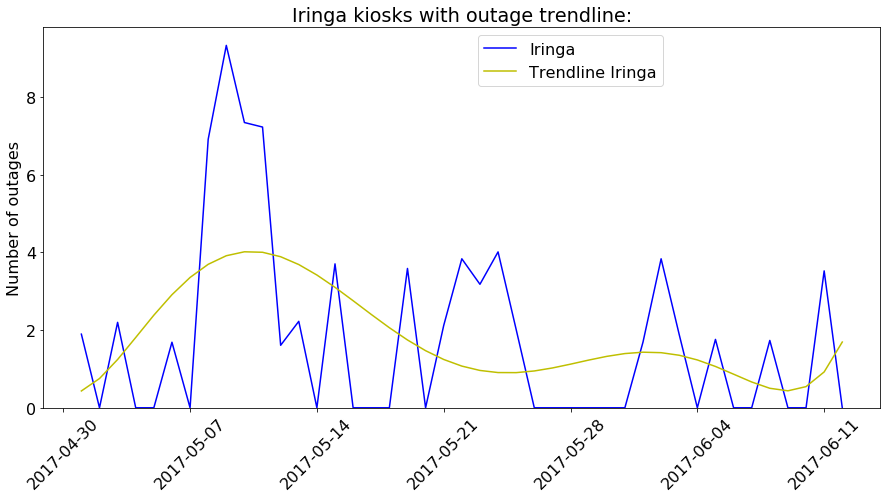

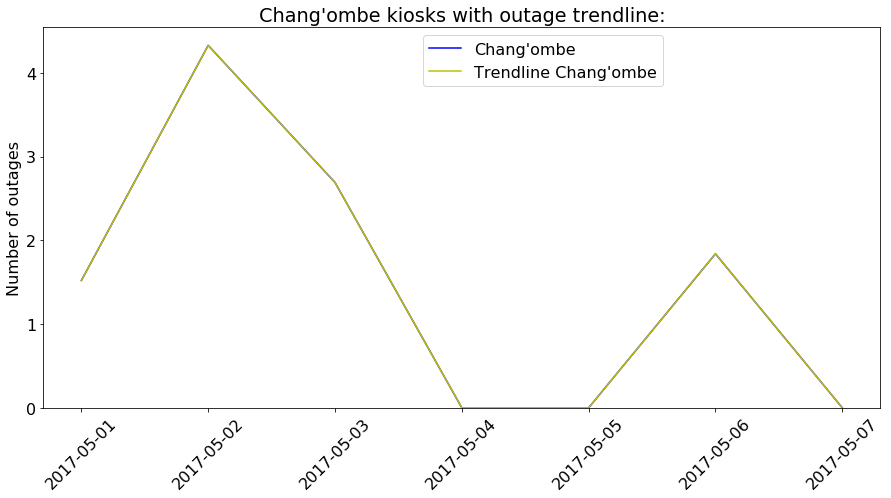

In [41]:
#@interact(dispenser=['Busiro 119', 'Busiro 121', 'Dei 010', 'Kikondo 117'], x=(0.0,1.0,0.05))
def ff(dispenser, x):
    #dispenser = 'Dei 010'
    rr = resultset_outages_zero
    rr['DeltaMinutes'] = 24 * 60
    r = resultset_outages[resultset_outages.Dispenser == dispenser]
    wd = resultset[resultset.Dispenser == dispenser]

    r = r.append(rr[rr.Dispenser == dispenser])
    r1 = r.groupby(['Dispenser', 'Date']).DeltaMinutes.sum().reset_index()
    r2 = wd.groupby(['Dispenser', 'Date']).Water_dispensed.sum().reset_index()
    r = pd.merge(r2, r1, on=['Date', 'Dispenser'], how='outer').fillna(0)

    delta = r.Date.max() - r.Date.min()
    emptyDB = pd.DataFrame(index=pd.date_range(r.Date.min(), periods=delta.days), columns=['Date', 'Dispenser', 'DeltaMinutes', 'Water_dispensed'])
    emptyDB.Date = pd.date_range(r.Date.min(), periods=delta.days)
    emptyDB.Dispenser = r.get_value(r.index[0],'Dispenser')
    emptyDB.DeltaMinutes = 0
    emptyDB.Water_dispensed = 0
    
    res = pd.concat([emptyDB, r], ignore_index=True, join='outer')
    res1 = res.groupby(['Date', 'Dispenser']).DeltaMinutes.sum().reset_index()
    res2 = res.groupby(['Date', 'Dispenser']).Water_dispensed.sum().reset_index()
    res119 =  pd.merge(res1, res2, on=['Date', 'Dispenser'], how='outer').fillna(0)
    res119 = res119[['Date', 'DeltaMinutes']]
    res119.DeltaMinutes = res119.DeltaMinutes/60
    res119.columns = ['Date', 'Busiro119']
    
    res = res119
    i = res.index
    y = res.Busiro119
    z = np.polyfit(i, y, 6)
    p = np.poly1d(z)
    
    plt.title(dispenser + ' kiosks with outage trendline:')
    plt.plot(res.Date,res.Busiro119, 'b') 
    plt.plot(res.Date, p(i),"y")
    plt.ylabel('Number of outages')
    plt.legend ( (dispenser, 'Trendline ' + dispenser), bbox_to_anchor=(x, 1) )
    plt.ylim(ymin=0)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.show()
    
for dispenser in ['Busiro 119', 'Busiro 121', 'Dei 010', 'Kikondo 117', 'Nyerere', 'Zahanati', 'Arusha B', 'Iringa', "Chang'ombe"]:
    ff(dispenser, 0.75)

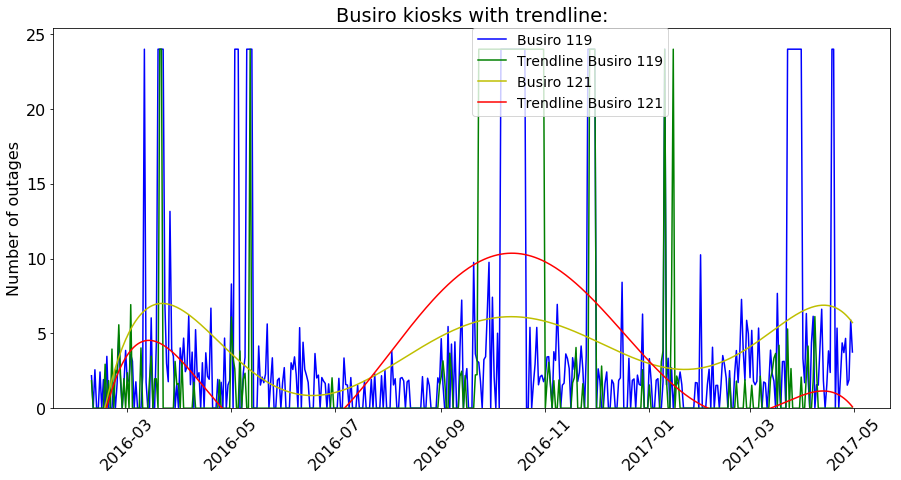

In [42]:
#@interact(x=(0.0,1.0,0.05))
def ff(x):
    dispenser = 'Busiro 119'
    rr = resultset_outages_zero
    rr['DeltaMinutes'] = 24 * 60
    r = resultset_outages[resultset_outages.Dispenser == dispenser]
    wd = resultset[resultset.Dispenser == dispenser]
    r.Date = pd.to_datetime(r.Date)
    wd.Date = pd.to_datetime(wd.Date)
     
    r = r.append(rr[rr.Dispenser == dispenser])
    r1 = r.groupby(['Dispenser', 'Date']).DeltaMinutes.sum().reset_index()
    r2 = wd.groupby(['Dispenser', 'Date']).Water_dispensed.sum().reset_index()
    r = pd.merge(r2, r1, on=['Date', 'Dispenser'], how='outer').fillna(0)

    delta = r.Date.max() - r.Date.min()
    emptyDB = pd.DataFrame(index=pd.date_range(r.Date.min(), periods=delta.days), columns=['Date', 'Dispenser', 'DeltaMinutes', 'Water_dispensed'])
    emptyDB.Date = pd.date_range(r.Date.min(), periods=delta.days)
    emptyDB.Dispenser = r.get_value(r.index[0],'Dispenser')
    emptyDB.DeltaMinutes = 0
    emptyDB.Water_dispensed = 0
    
    res = pd.concat([emptyDB, r], ignore_index=True, join='outer')
    res1 = res.groupby(['Date', 'Dispenser']).DeltaMinutes.sum().reset_index()
    res2 = res.groupby(['Date', 'Dispenser']).Water_dispensed.sum().reset_index()
    res119 =  pd.merge(res1, res2, on=['Date', 'Dispenser'], how='outer').fillna(0)
    res119 = res119[['Date', 'DeltaMinutes']]
    res119.DeltaMinutes = res119.DeltaMinutes/60
    res119.columns = ['Date', 'Busiro119']
    
    dispenser = 'Busiro 121'
    rr = resultset_outages_zero
    rr['DeltaMinutes'] = 24 * 60
    r = resultset_outages[resultset_outages.Dispenser == dispenser]
    wd = resultset[resultset.Dispenser == dispenser]
    r.Date = pd.to_datetime(r.Date)
    wd.Date = pd.to_datetime(wd.Date)
     
    r = r.append(rr[rr.Dispenser == dispenser])
    r1 = r.groupby(['Dispenser', 'Date']).DeltaMinutes.sum().reset_index()
    r2 = wd.groupby(['Dispenser', 'Date']).Water_dispensed.sum().reset_index()
    r = pd.merge(r2, r1, on=['Date', 'Dispenser'], how='outer').fillna(0)
    r.Date = pd.to_datetime(r.Date)

    delta = r.Date.max() - r.Date.min()
    emptyDB = pd.DataFrame(index=pd.date_range(r.Date.min(), periods=delta.days), columns=['Date', 'Dispenser', 'DeltaMinutes', 'Water_dispensed'])
    emptyDB.Date = pd.date_range(r.Date.min(), periods=delta.days)
    emptyDB.Dispenser = r.get_value(r.index[0],'Dispenser')
    emptyDB.DeltaMinutes = 0
    emptyDB.Water_dispensed = 0
    
    res = pd.concat([emptyDB, r], ignore_index=True, join='outer')
    
    res1 = res.groupby(['Date', 'Dispenser']).DeltaMinutes.sum().reset_index()
    res2 = res.groupby(['Date', 'Dispenser']).Water_dispensed.sum().reset_index()
    res121 =  pd.merge(res1, res2, on=['Date', 'Dispenser'], how='outer').fillna(0)
    res121 = res121[['Date', 'DeltaMinutes']]
    res121.DeltaMinutes = res121.DeltaMinutes/60
    res121.columns = ['Date', 'Busiro121']
    
    res = pd.merge(res119, res121, on=['Date'], how='outer').fillna(0)
    
    i = res.index
    y = res.Busiro119
    z = np.polyfit(i, y, 6)
    p = np.poly1d(z)
    y2 = res.Busiro121
    z2 = np.polyfit(i, y2, 6)
    p2 = np.poly1d(z2)
        
    plt.title('Busiro kiosks with trendline:')
    plt.plot(res.Date,res.Busiro119, 'b') 
    plt.plot(res.Date,res.Busiro121, 'g') 
    plt.plot(res.Date, p(i),"y")
    plt.plot(res.Date, p2(i),"r")
    plt.ylabel('Number of outages')
    plt.legend(('Busiro 119', 'Trendline Busiro 119', 'Busiro 121', 'Trendline Busiro 121'), bbox_to_anchor=(x, 1), loc=2, borderaxespad=0., fontsize=14)
    plt.ylim(ymin=0)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)

ff(0.5)

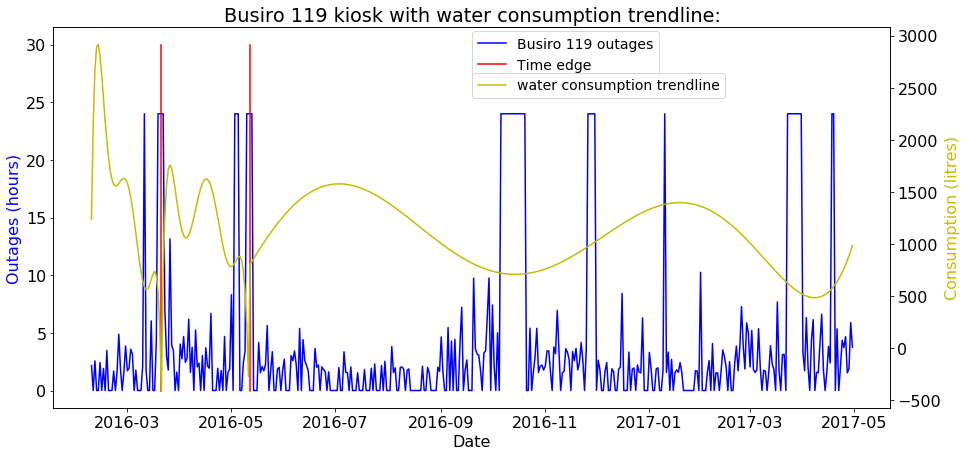

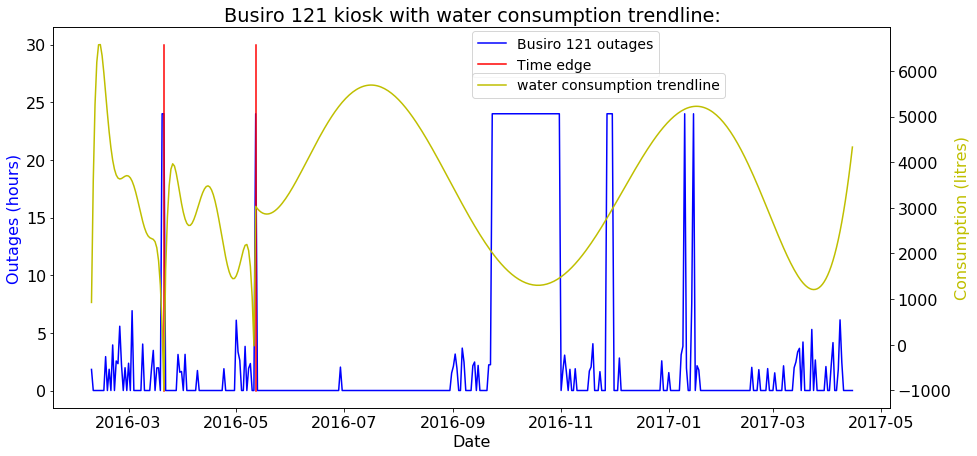

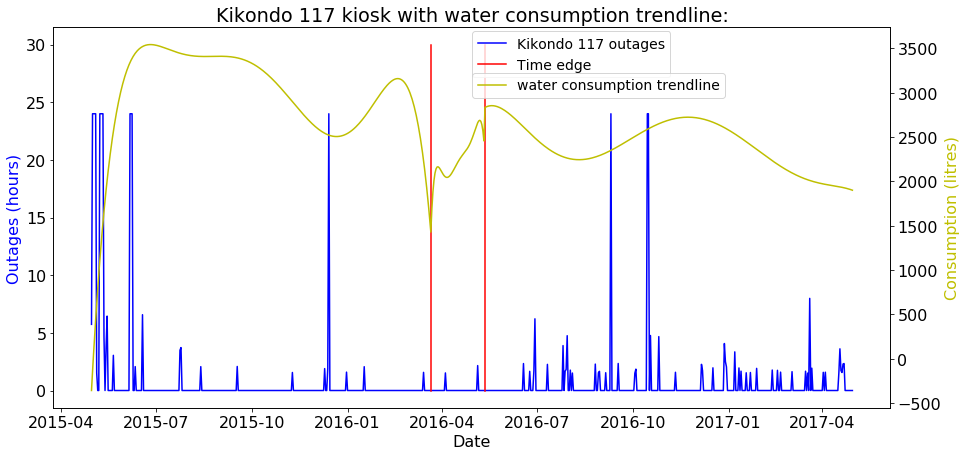

In [43]:
#@interact(dispenser=['Busiro 119', 'Busiro 121', 'Kikondo 117'], x=(0.0,1.0,0.05))
def ff(dispenser, x):
    rr = resultset_outages_zero
    rr['DeltaMinutes'] = 24 * 60
    r = resultset_outages[resultset_outages.Dispenser == dispenser]
    wd = resultset[resultset.Dispenser == dispenser]
     
    r = r.append(rr[rr.Dispenser == dispenser])
    r1 = r.groupby(['Dispenser', 'Date']).DeltaMinutes.sum().reset_index()
    r2 = wd.groupby(['Dispenser', 'Date']).Water_dispensed.sum().reset_index()
    r = pd.merge(r2, r1, on=['Date', 'Dispenser'], how='outer').fillna(0)

    delta = r.Date.max() - r.Date.min()
    emptyDB = pd.DataFrame(index=pd.date_range(r.Date.min(), periods=delta.days), columns=['Date', 'Dispenser', 'DeltaMinutes', 'Water_dispensed'])
    emptyDB.Date = pd.date_range(r.Date.min(), periods=delta.days)
    emptyDB.Dispenser = r.get_value(r.index[0],'Dispenser')
    emptyDB.DeltaMinutes = 0
    emptyDB.Water_dispensed = 0
    
    res = pd.concat([emptyDB, r], ignore_index=True, join='outer')
    res1 = res.groupby(['Date', 'Dispenser']).DeltaMinutes.sum().reset_index()
    res2 = res.groupby(['Date', 'Dispenser']).Water_dispensed.sum().reset_index()
    res121 =  pd.merge(res1, res2, on=['Date', 'Dispenser'], how='outer').fillna(0)
    res121 = res121[['Date', 'DeltaMinutes', 'Water_dispensed']]
    res121.DeltaMinutes = res121.DeltaMinutes/60
    res121.columns = ['Date', 'Busiro121', 'Busiro121_consumption']
    
    res = res121
        
    i = res.index
    y = res.Busiro121
    z = np.polyfit(i, y, 6)
    p = np.poly1d(z)

    res_1 = res[res.Date <= '2016-03-21']
    i1 = res_1.index
    y1 = res_1.Busiro121_consumption
    z1 = np.polyfit(i1, y1, 6)
    p1 = np.poly1d(z1)
    t1 = res_1.index.map(lambda x: p1(x))

    res_2 = res[(res.Date > '2016-03-21') & (res.Date < '2016-05-12')]
    i2 = res_2.index
    y2 = res_2.Busiro121_consumption
    z2 = np.polyfit(i2, y2, 6)
    p2 = np.poly1d(z2)
    t2 = res_2.index.map(lambda x: p2(x))
    
    res_3 = res[res.Date >= '2016-05-12']
    i3 = res_3.index
    y3 = res_3.Busiro121_consumption
    z3 = np.polyfit(i3, y3, 6)
    p3 = np.poly1d(z3)
    t3 = res_3.index.map(lambda x: p3(x))
    
    t = np.concatenate((t1, t2, t3))
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(res.Date,res.Busiro121, 'b-')
    ax1.plot(('2016-03-21', '2016-03-21'),(0, 30), 'r')
    ax1.plot(('2016-05-12', '2016-05-12'),(0, 30),'r')
    ax2.plot(res.Date, t, 'y')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Outages (hours)', color='b')
    ax2.set_ylabel('Consumption (litres)', color='y')
    #ax1.set_xticklabels([ 'March-16', 'April-16', 'May-16', 'June-16', 'July-16', 'August-16', 'September-16', 'October-16', 'November-16', 'December-16', 'January-17'], rotation=50)
    
    plt.title(dispenser + ' kiosk with water consumption trendline:')
    ax1.legend ((dispenser + " outages", 'Time edge'), bbox_to_anchor=(x, 0.9899), loc=2, borderaxespad=0., fontsize=14)
    ax2.legend(("water consumption trendline", '    '), bbox_to_anchor=(x, 0.88), loc=2, borderaxespad=0., fontsize=14)

    plt.show()
    
for dispenser in ['Busiro 119', 'Busiro 121', 'Kikondo 117']:
    ff(dispenser, 0.5)

<a id="section6"></a>
# Appendix (long periods of inactivity before May 2016)


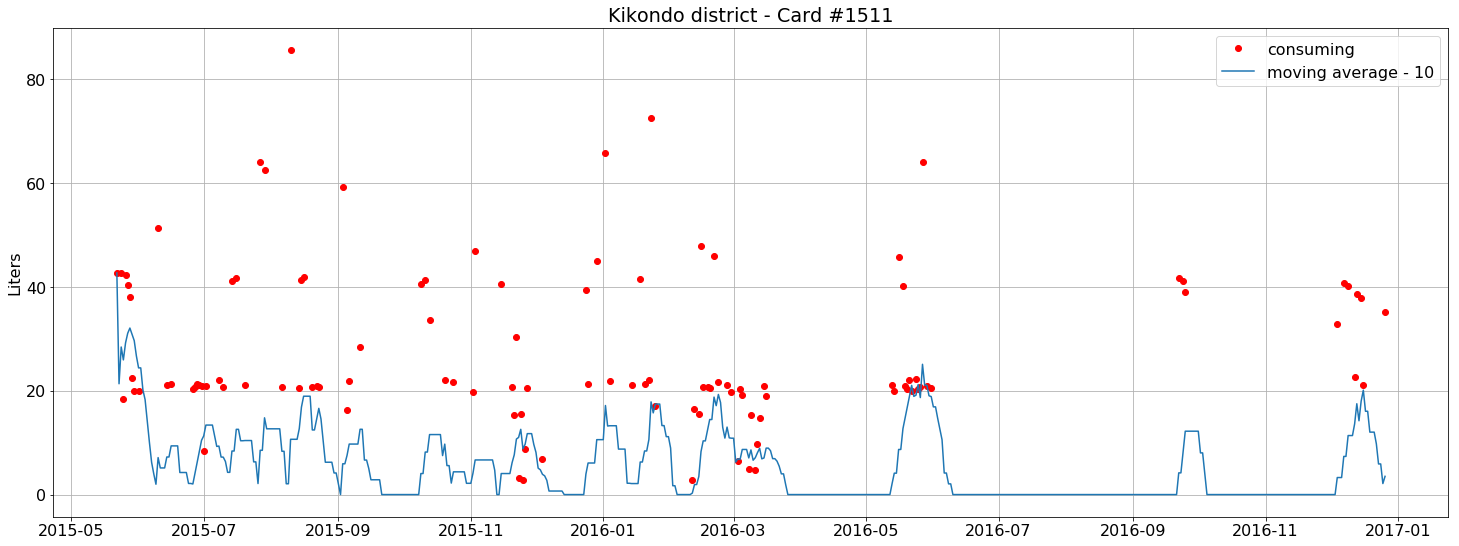

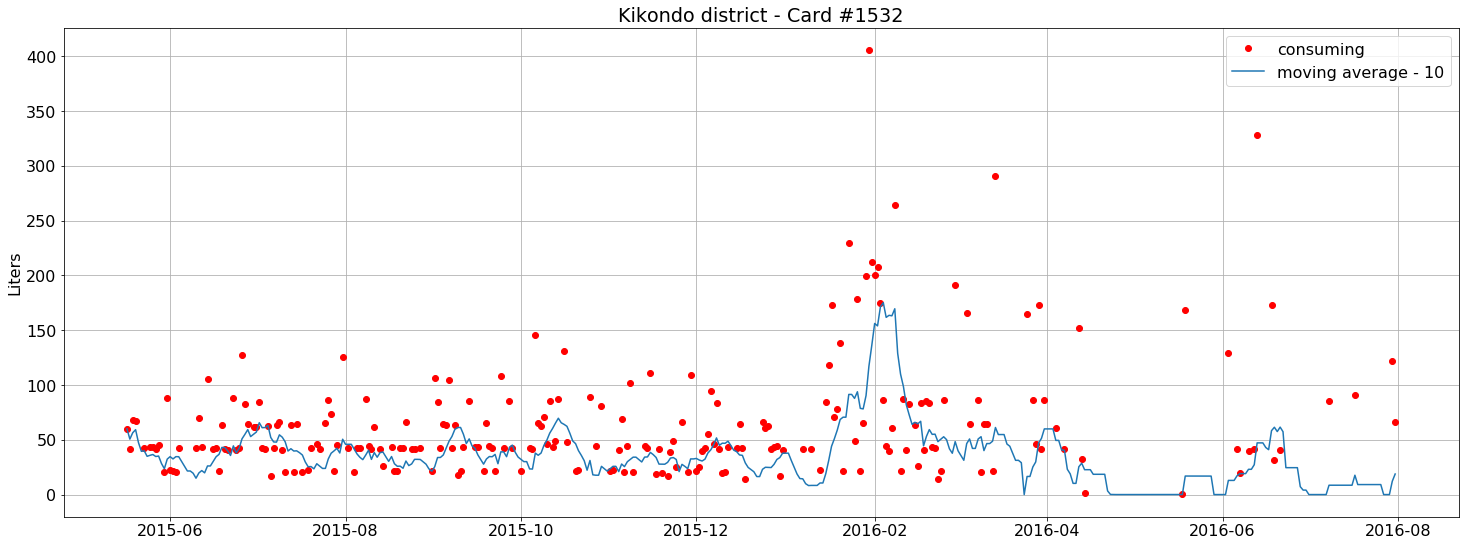

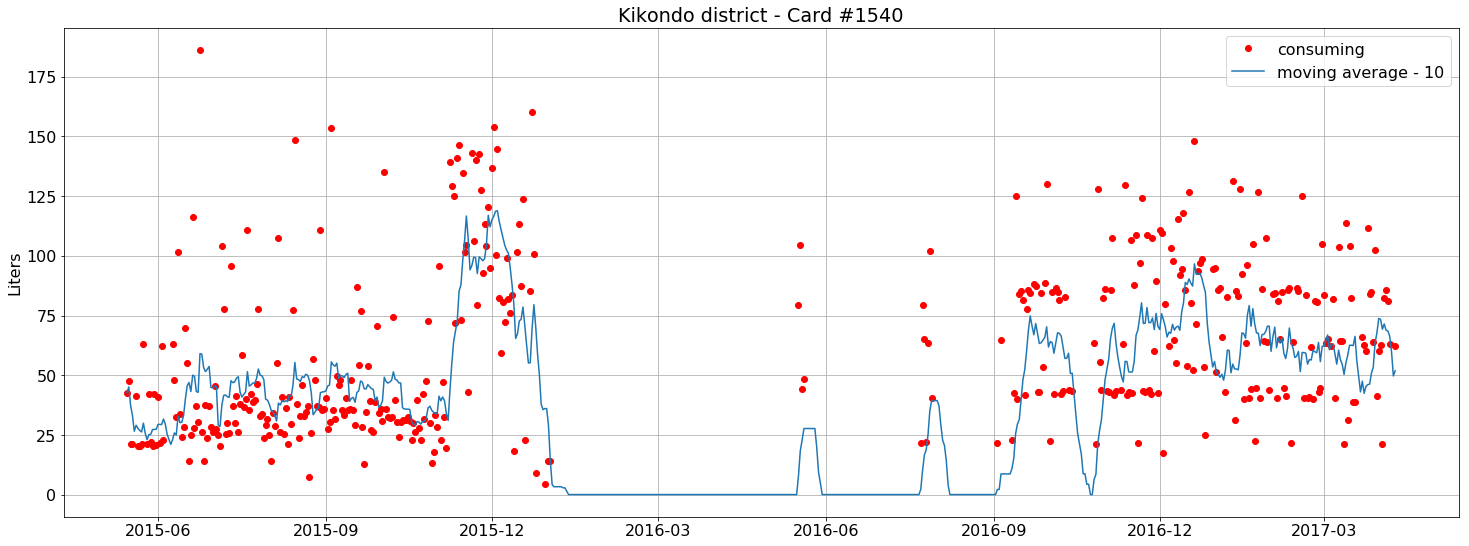

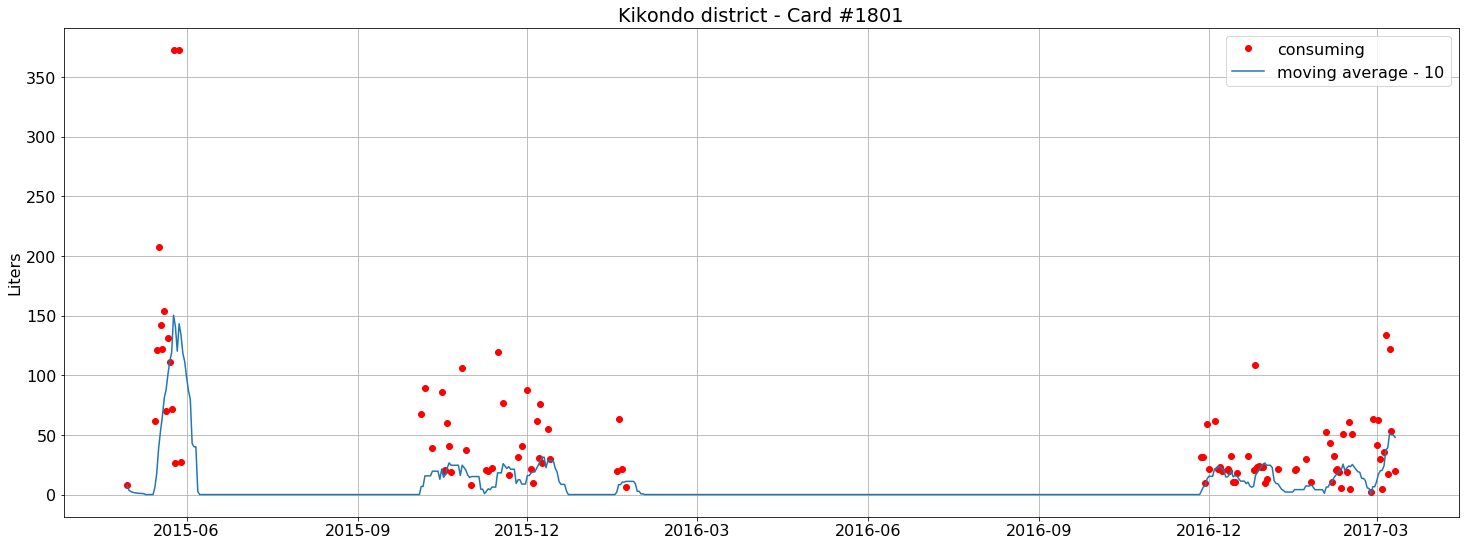

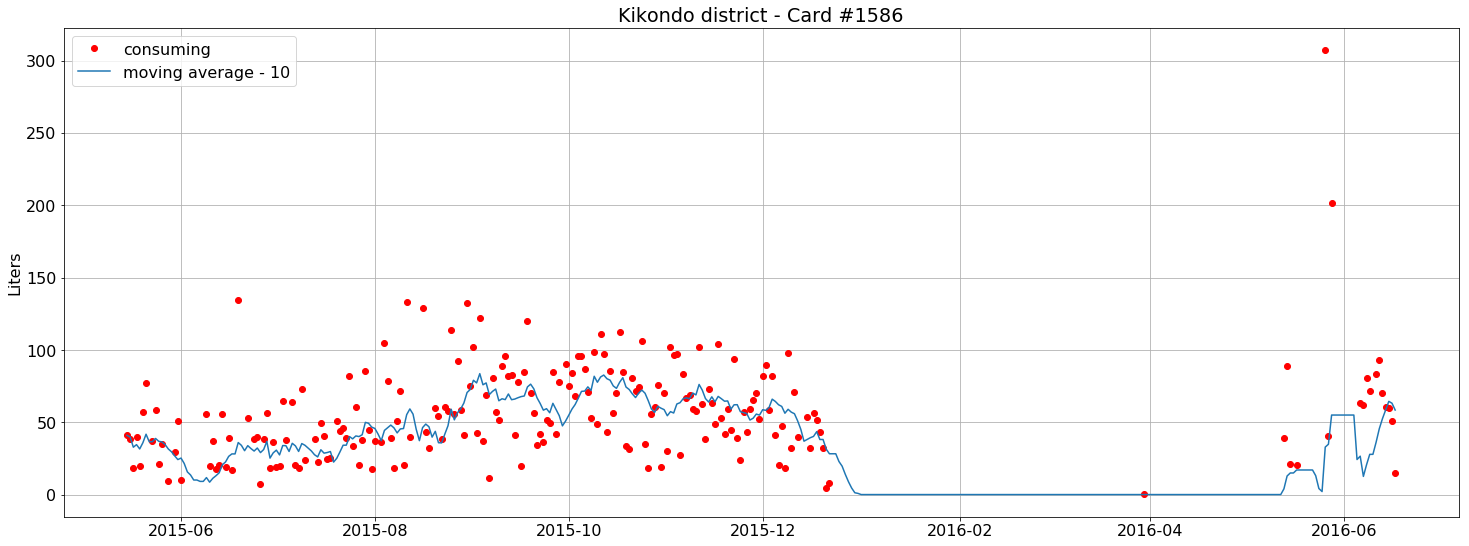

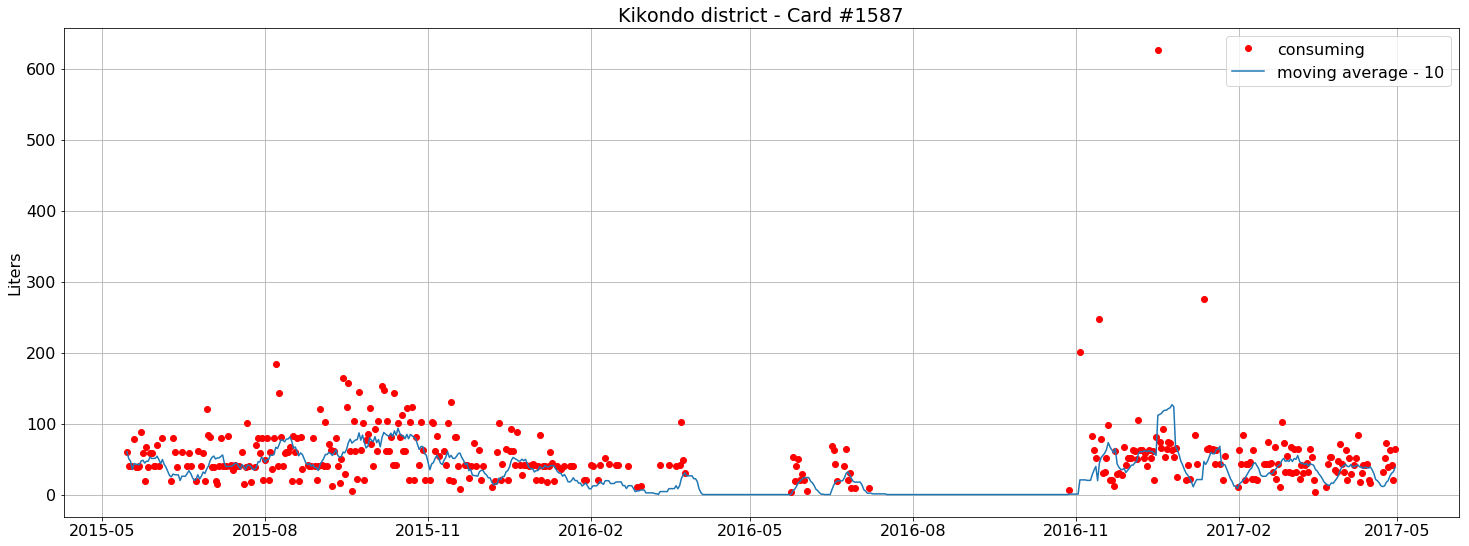

In [44]:
def printGraph(card):
    data = getCardData(card, 'Kikondo')
    if(len(data) > 0): 
        x = data.Date
        y = data.Water_dispensed.map(lambda x: f(x))
        ma10 = data.MA10

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 25
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        ax = plt.axes()
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)
        ax.set_ylabel("Liters")

        plt.plot(x,y, 'ro')
        plt.plot(x,ma10)
        plt.legend ( ("consuming", "moving average - 10") )
        plt.title('Kikondo district - Card #' + card)
        plt.show()
    
for card in ['1511', '1532', '1540', '1801', '1586', '1587']:
    printGraph(card)

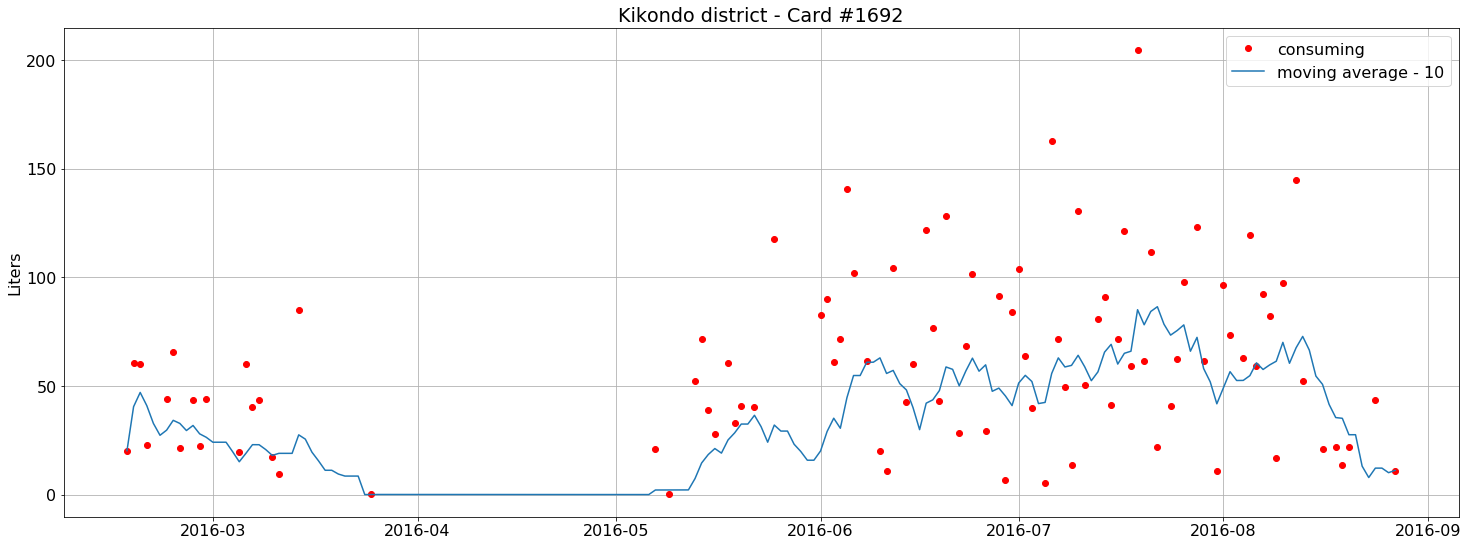

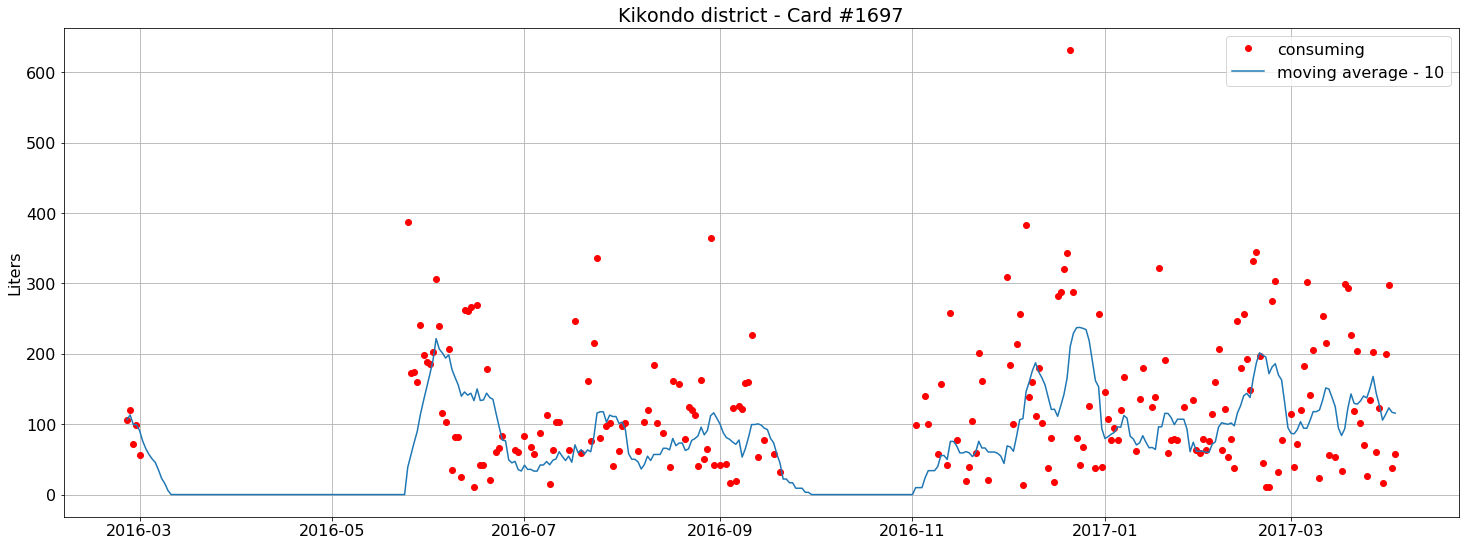

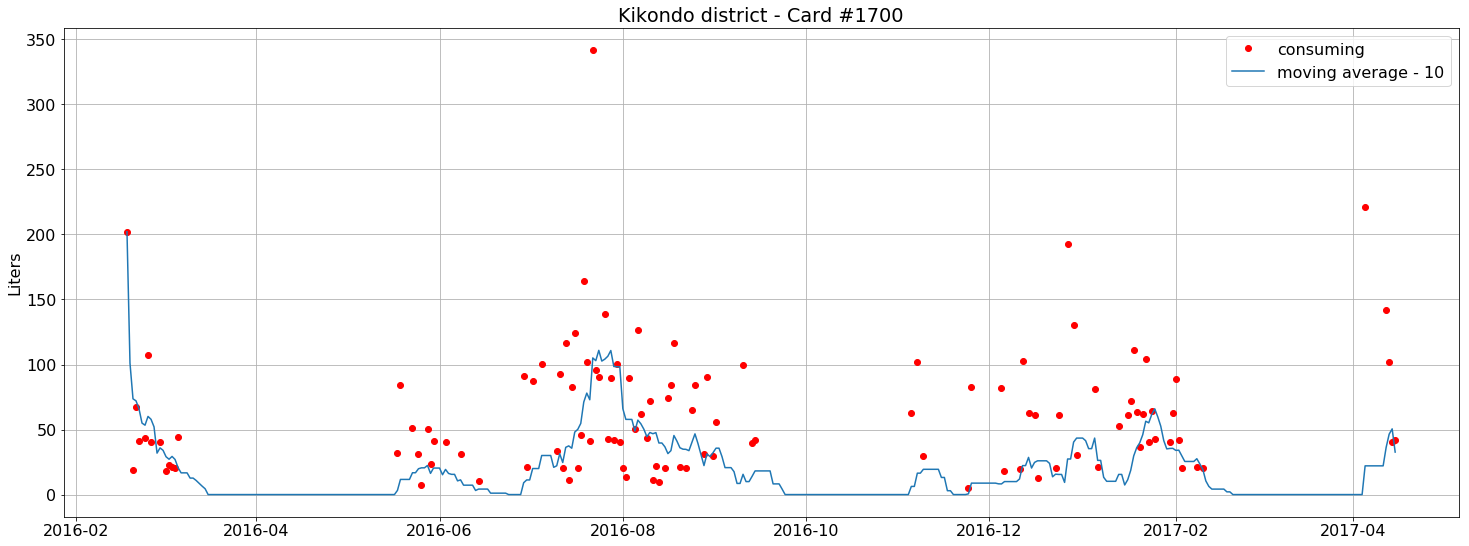

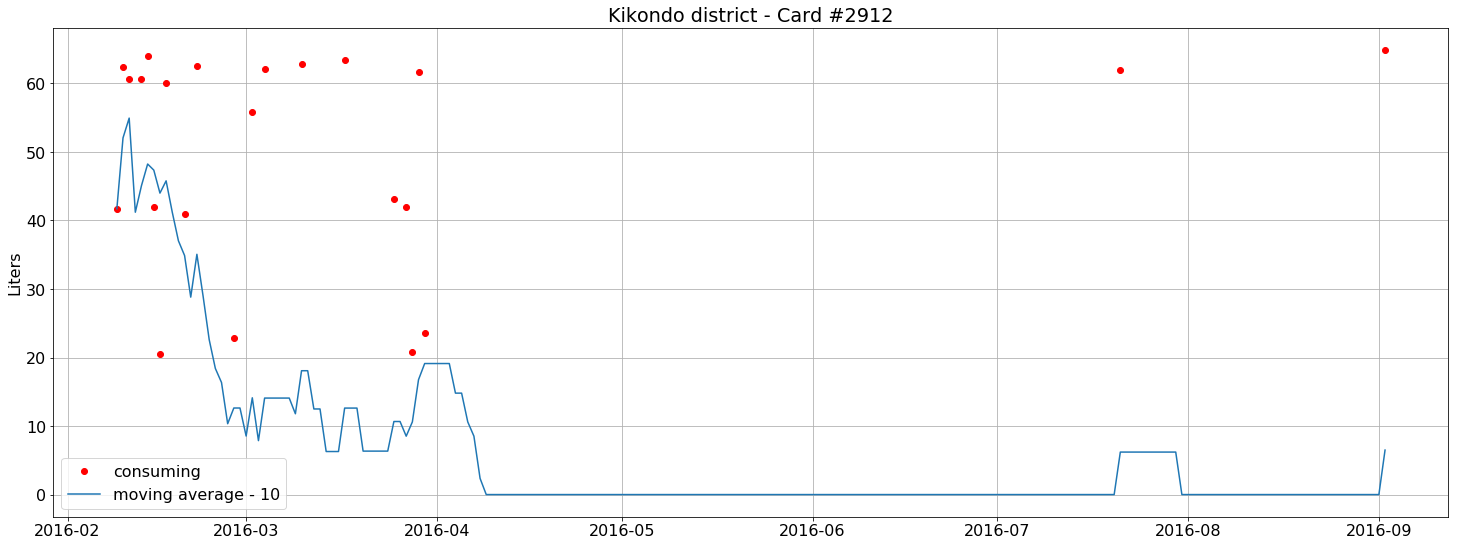

In [45]:
#@interact(card=['1692', '1697', '1700', '2912'])
def printGraph(card):
    #card = '1692'
    data = getCardData(card, 'Busiro')
     
    if(len(data) > 0): 
        x = data.Date
        y = data.Water_dispensed.map(lambda x: f(x))
        ma10 = data.MA10

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 25
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size
        ax = plt.axes()
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)
        ax.set_ylabel("Liters")

        plt.plot(x,y, 'ro')
        plt.plot(x,ma10)
        plt.legend ( ("consuming", "moving average - 10") )
        plt.title('Kikondo district - Card #' + card)
        plt.show()
    
for card in ['1692', '1697', '1700', '2912']:
    printGraph(card)